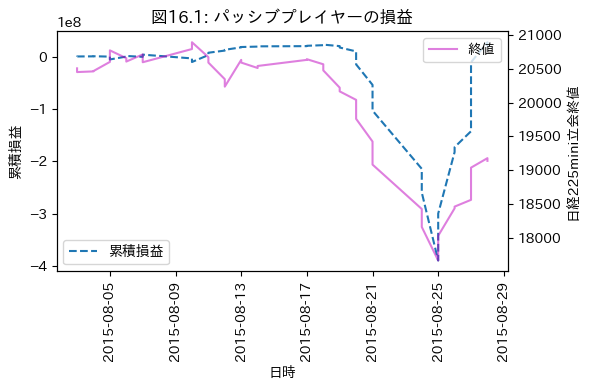

In [14]:
aa=-(results.posxp.cumsum()-results.pos.cumsum()*results.p9)
plotanalysis(aa,results.p9,"累積損益","終値","累積損益","日経225mini立会終値"\
            ,"図16.1: パッシブプレイヤーの損益")
plt.show()

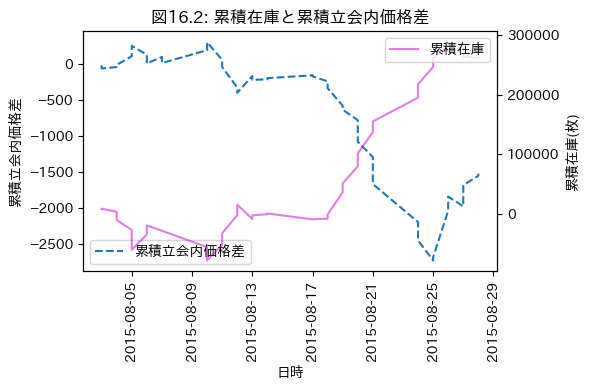

In [15]:
plotanalysis(results.co.cumsum(),results.pos.cumsum()\
             ,"累積立会内価格差","累積在庫","累積立会内価格差"\
             ,"累積在庫(枚)","図16.2: 累積在庫と累積立会内価格差")
plt.show()

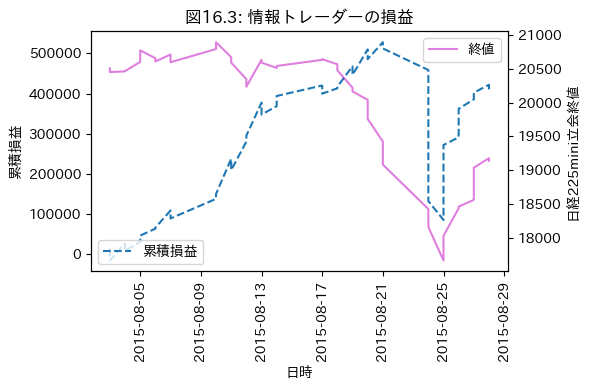

<Figure size 640x480 with 0 Axes>

In [16]:
aa=-(results2.cumposxp-results2.cumpos*results.p9)
plotanalysis(aa,results2.p9,"累積損益","終値","累積損益","日経225mini立会終値"\
            ,"図16.3: 情報トレーダーの損益")
#plt.savefig("1603.jpeg",dpi=600)
plt.show()

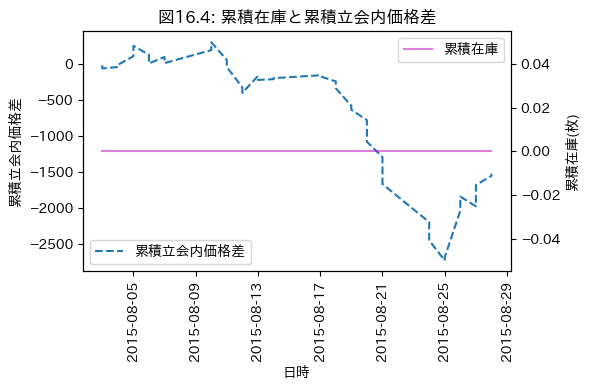

In [17]:
plotanalysis(results2.co.cumsum(),results2.cumpos\
             ,"累積立会内価格差","累積在庫","累積立会内価格差"\
             ,"累積在庫(枚)","図16.4: 累積在庫と累積立会内価格差")
plt.show()

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime, date,time
import pandas as pd
import japanize_matplotlib

In [2]:
buf_path="C:/users/hm201/documents/Database/n225/tick/"
filenames=["n225m201508Sep.csv"]

In [3]:
if __name__ == "__main__":    
    start_now=datetime.now()
    for i,filename in enumerate(filenames):
        ts=pd.read_csv(buf_path+filename,index_col=0,header=0,parse_dates=True)
        #ts=ts.tz_localize('UTC')    
        ts=ts.tz_convert('Asia/Tokyo')            
        print(ts.index[0],len(ts))
        if i==0:
            markets=ts
        else:
            markets=pd.concat([markets,ts],axis=0)
    print(datetime.now()-start_now,'-----------------------')

2015-08-03 09:00:00+09:00 3070843
0:00:16.705391 -----------------------


In [4]:
def itayose_zaraba_from_markets(df):
    lenprice=len(df)
    p0=df.Price.iloc[0] 
    p9=df.Price.iloc[-1] 
    for k,price0 in enumerate(df.Price):#itayose open
        if price0!=p0:
            break
    v0=df.iloc[:k,3].sum()
    price_r=df.iloc[::-1]
    for kk,price0 in enumerate(price_r.Price):#itayose close
        if price0!=p9:
            break
    v9=df.iloc[-kk:,3].sum()    
    return df[k:-kk].copy(),v0,v9,p0,p9#zaraba market  

In [5]:
def trading(p,b,a,v,posxprice,pos,cost):
    if p<=b:
        pos+=v
        posxprice+=v*(p+cost)
    elif p>=a:
        pos-=v
        posxprice-=v*(p-cost)
    return posxprice,pos

In [6]:
def passive_player(tmp):#---------------------------------------
    zaraba,ita_v0,ita_v9,p0,p9=itayose_zaraba_from_markets(tmp)#ザラバ
    co=p9-p0
    posxprice=0
    pos=0
    zaraba_list=zaraba.to_numpy().tolist()
    vv=0
    for aa in zaraba_list:
        p=aa[0]
        b=aa[1]
        a=aa[2]          
        v=aa[3]
        bab0=aa[4]
        posxprice,pos=trading(p,b,a,v,posxprice,pos,1/8)
    zpl=posxprice-pos*p9
    return zpl,posxprice,pos,co,p0,p9,ita_v0,ita_v9#---------------------

In [7]:
def passive_player_trading(markets):# passive mm
    results=[]
    da=[]
    price0=[] #init
    p99=markets.Price.iloc[0]
    indexdates=pd.unique(markets.index.date)
    for indexdate,indexdate1 in zip(indexdates[:-1],indexdates[1:]):
        tmp=pd.DataFrame()
        tmp=(markets.loc[str(indexdate)+' 8:45:00+09:00':
                    str(indexdate)+' 15:15:00+09:00'])
        if not tmp.empty:
            zpl,posxprice,pos,co,p0,p9,ita_v0,ita_v9=passive_player(tmp)
            da.append(indexdate)
            results.append([zpl,posxprice,pos,co,p0,p9,ita_v0,ita_v9])
        tmp=pd.DataFrame()
        tmp=(markets.loc[str(indexdate)+' 16:30:00+09:00':
                    str(indexdate1)+' 5:30:00+09:00'])
        if not tmp.empty:
            zpl,posxprice,pos,co,p0,p9,ita_v0,ita_v9=passive_player(tmp)
            da.append(indexdate)
            results.append([zpl,posxprice,pos,co,p0,p9,ita_v0,ita_v9])
    results=pd.DataFrame(results,index=da,
                columns=['zpl','posxp','pos','co','p0','p9','ita_v0','ita_v9'])
    return results

In [8]:
if __name__ == "__main__":    
    start_now=datetime.now()
    results=passive_player_trading(markets)
    print(datetime.now()-start_now,'-----------------------')

0:00:03.142373 -----------------------


In [9]:
def plotanalysis(df1,df2,label1,label2,ylabel1,ylabel2,title):
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(df1,label=label1,linestyle='--')
    plt.ylabel(ylabel1)
    plt.xlabel("日時")
    plt.xticks(rotation=90)
    ax1.legend(loc="lower left")
    ax2 = ax1.twinx()  # 2つのプロットを関連付ける
    ax2.plot(df2,label=label2,c='m',alpha=0.5)
    plt.ylabel(ylabel2)
    plt.xlabel("日時")
    ax2.legend(loc="upper right")
    plt.title(title)
    plt.tight_layout()
    #plt.savefig(title[:5]+'.jpeg',dpi=600)
    plt.show()

16.附録.D コードの解説(情報トレーダーの戦略)

入力[10]のtrading2は、入力[5]のtradingの累積在庫に制限を設けている。

入力[11]のpassive_player2は入力[6]のpassive_playerに寄り付きと引けの板寄せで在庫の調整を行っている。目標は累積在庫ゼロである。,入力[12]と入力[7]の違いは在庫の扱いである。入力[12]のpassive_player_trading2では立会の在庫をすてべ累積在庫の置き換えている。


In [10]:
def trading2(p,b,a,v,posxprice,pos,poslimit,cost):
    if p<=b and pos<=poslimit:
        pos+=v
        posxprice+=v*(p+cost)
    elif p>=a and pos>=-poslimit:
        pos-=v
        posxprice-=v*(p-cost)
    return posxprice,pos

In [11]:
def passive_player2(tmp,cumpos,cumposxp):#------------------------------
    zaraba,ita_v0,ita_v9,p0,p9=itayose_zaraba_from_markets(tmp)#ザラバ
    if cumpos>=0 and cumpos>ita_v0:
        settle0=ita_v0
    elif cumpos<0 and -cumpos>ita_v0:
        settle0=-ita_v0
    else:
        settle0=cumpos
    cumpos-=settle0#++++寄り付きの在庫調整+++++++++++
    cumposxp-=settle0*p0
    co=p9-p0
    posxprice=cumposxp
    pos=cumpos
    zaraba_list=zaraba.iloc[1:].to_numpy().tolist()
    for aa in zaraba_list:
        p=aa[0]
        b=aa[1]
        a=aa[2]          
        v=aa[3]
        bab0=aa[4]
        posxprice,pos=trading2(p,b,a,v,posxprice,pos,100,1/8)
    cumposxp=posxprice
    cumpos=pos 
    if cumpos>=0 and cumpos>ita_v9:
        settle9=ita_v9
    elif cumpos<0 and -cumpos>ita_v9:
        settle9=-ita_v9
    else:
        settle9=cumpos
    cumpos-=settle9 #++++引けの在庫調整+++++++++++
    cumposxp-=settle9*p9
    return cumposxp,cumpos,p0,p9,co,ita_v0,ita_v9#---------------------

In [12]:
def passive_player_trading2(markets):# passive mm
    results=[]
    da=[]
    price0=[] #init
    cumpos=0
    cumposxp=0
    indexdates=pd.unique(markets.index.date)
    for indexdate,indexdate1 in zip(indexdates[:-1],indexdates[1:]):
        tmp=pd.DataFrame()
        tmp=(markets.loc[str(indexdate)+' 8:45:00+09:00':
                    str(indexdate)+' 15:15:00+09:00'])
        if not tmp.empty:
            cumposxp,cumpos,p0,p9,co,ita_v0,ita_v9\
            =passive_player2(tmp,cumpos,cumposxp)
            da.append(indexdate)
            results.append([cumposxp,cumpos,co,p0,p9,ita_v0,ita_v9])
        tmp=pd.DataFrame()
        tmp=(markets.loc[str(indexdate)+' 16:30:00+09:00':
                    str(indexdate1)+' 5:30:00+09:00'])
        if not tmp.empty:
            cumposxp,cumpos,p0,p9,co,ita_v0,ita_v9\
            =passive_player2(tmp,cumpos,cumposxp)
            da.append(indexdate)
            results.append([cumposxp,cumpos,co,p0,p9,ita_v0,ita_v9])
    results=pd.DataFrame(results,index=da,
                         columns=['cumposxp','cumpos','co','p0','p9'\
                                  ,'ita_v0','ita_v9'])
    return results

In [13]:
if __name__ == "__main__":    
    start_now=datetime.now()
    results2=passive_player_trading2(markets)
    print(datetime.now()-start_now,'-----------------------')

0:00:03.740511 -----------------------
